In [1]:
#%env CUDA_VISIBLE_DEVICES=1

In [2]:
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from era_data import TabletEraDataset
from era_model import EraClassifier
from glob import glob
from era_data import TabletPeriodDataset
import pandas as pd
from matplotlib import pyplot as plt
from itertools import islice
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression

# Load data and model

In [5]:
IMG_DIR = 'output/images_preprocessed'

In [42]:
VERSION_NAME = 'genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur'

In [44]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur/checkpoints/epoch=14-step=91078.ckpt'

In [45]:
num_classes = len(set(TabletPeriodDataset.GENRE_INDICES.values())) + 2
num_classes

18

In [46]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 710 ms, sys: 431 ms, total: 1.14 s
Wall time: 2.54 s


In [47]:
model.to(device);

In [48]:
model.eval();

In [49]:
train_ids = pd.read_csv(f'output/clf_ids/genre-train-{VERSION_NAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/genre-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [50]:
len(train_ids), len(test_ids)

(97140, 500)

In [51]:
### make sure era_data.py file, TabletPeriodDataset's method "__get_item__" returns the GENRE, not the period

ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


# Calculate predictions

In [52]:
from itertools import islice
import scipy

In [ ]:
import numpy as np
from PIL import Image

def collate_fn(batch):
    # Unsqueeze the matrix (the first element of each tuple)
    
    unsqueezed_data = [torch.from_numpy(np.array(Image.fromarray(sample[0]).resize((178, 218), Image.NEAREST))).unsqueeze(0) for sample in batch]
    labels = torch.from_numpy(np.array([sample[2] for sample in batch]))

    # Concatenate the unsqueezed matrices into a new tensor
    unsqueezed_batch_data = torch.cat(unsqueezed_data, dim=0)

    return unsqueezed_batch_data, labels

In [53]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, collate_fn = collate_fn, shuffle=False, num_workers=1)

In [54]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [55]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [56]:
y_true.shape, logits.shape

((489,), (489, 18))

In [57]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [58]:
y_pred.shape, y_prob.shape

((489,), (489, 18))

In [59]:
(y_pred == y_true).mean()

0.30265848670756645

# Check metrics

In [60]:
from collections import Counter

In [61]:
# Initialize an empty result dictionary
idx2genre = {}

# Use a dictionary comprehension to reverse the dictionary
for genre, index in TabletPeriodDataset.GENRE_INDICES.items():
    idx2genre.setdefault(index, []).append(genre)

print(idx2genre)

{1: ['Administrative', 'Administrative ?'], 2: ['Letter', 'Letter ?', 'Historical'], 3: ['Legal', 'Legal ?'], 4: ['Royal/Monumental', 'Royal/Monumental ?', 'Royal/Monumental; Literary'], 5: ['Literary', 'Literary ?', 'Literary; Mathematical', 'Literary; Lexical', 'Literary; Administrative', 'Literary; Letter'], 6: ['Lexical', 'Lexical ?', 'Lexical; Literary', 'Lexical; Mathematical', 'Lexical; Literary; Mathematical', 'Lexical; School'], 7: ['Omen'], 8: ['uncertain', 'Other (see subgenre)'], 9: ['School', 'School ?', 'School; Literary'], 10: ['Mathematical', 'Mathematical ?'], 11: ['Prayer/Incantation', 'Prayer/Incantation ?'], 12: ['Scientific', 'Scientific ?'], 13: ['Ritual', 'Ritual ?'], 14: ['fake (modern)', 'fake (modern) ?'], 15: ['Astronomical'], 16: ['Private/Votive', 'Private/Votive ?']}


In [62]:
idx2genre[1], idx2genre[5]

(['Administrative', 'Administrative ?'],
 ['Literary',
  'Literary ?',
  'Literary; Mathematical',
  'Literary; Lexical',
  'Literary; Administrative',
  'Literary; Letter'])

In [63]:
def explain(genre):
    return (", ".join(genre))

In [72]:
set(y_pred)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [64]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
GENRE_LABELS = [explain(idx2genre[i]) for i in indices]
print(PERIOD_LABELS)

18
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20]


KeyError: 0

In [ ]:
print(classification_report(y_true, y_pred, target_names=GENRE_LABELS))

In [65]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2genre[i])) for i in COMMON_LABELS]

Common labels: (9)


[(1, 'Administrative, Administrative ?'),
 (2, 'Letter, Letter ?, Historical'),
 (3, 'Legal, Legal ?'),
 (4, 'Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary'),
 (5,
  'Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter'),
 (6,
  'Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School'),
 (7, 'Omen'),
 (9, 'School, School ?, School; Literary'),
 (11, 'Prayer/Incantation, Prayer/Incantation ?')]

In [66]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 8
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.0736196319018405 changed to "other"


In [67]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 8
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.3333333333333333 changed to "other"


In [68]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
GENRE_LABELS_C = [explain(idx2genre[i]) for i in indices_c]
print(GENRE_LABELS_C)

10
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
['Administrative, Administrative ?', 'Letter, Letter ?, Historical', 'Legal, Legal ?', 'Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary', 'Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter', 'Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School', 'Omen', 'uncertain, Other (see subgenre)', 'School, School ?, School; Literary', 'Prayer/Incantation, Prayer/Incantation ?']


In [69]:
print(classification_report(y_true_c, y_pred_c, target_names=GENRE_LABELS_C))

                                                                                                                precision    recall  f1-score   support

                                                                              Administrative, Administrative ?       0.55      0.91      0.69       140
                                                                                  Letter, Letter ?, Historical       0.48      0.09      0.15       109
                                                                                                Legal, Legal ?       0.37      0.08      0.13        91
                                              Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary       0.00      0.00      0.00        35
   Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter       0.04      0.04      0.04        23
Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathem

In [70]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[128,   1,   1,   0,   1,   0,   0,   9,   0,   0],
       [  1,  10,   0,   3,   3,   0,   3,  89,   0,   0],
       [ 34,   5,   7,   1,  13,   2,   0,  26,   3,   0],
       [ 13,   1,   2,   0,   2,   1,   0,  15,   1,   0],
       [ 11,   0,   1,   1,   1,   0,   0,   8,   0,   1],
       [ 13,   0,   0,   0,   2,   0,   0,   3,   0,   0],
       [  6,   0,   1,   0,   0,   0,   0,   3,   0,   0],
       [ 14,   0,   4,  10,   1,   0,   0,   7,   0,   0],
       [ 10,   0,   0,   1,   3,   0,   0,   1,   0,   0],
       [  3,   4,   3,   0,   0,   0,   0,   2,   0,   0]])

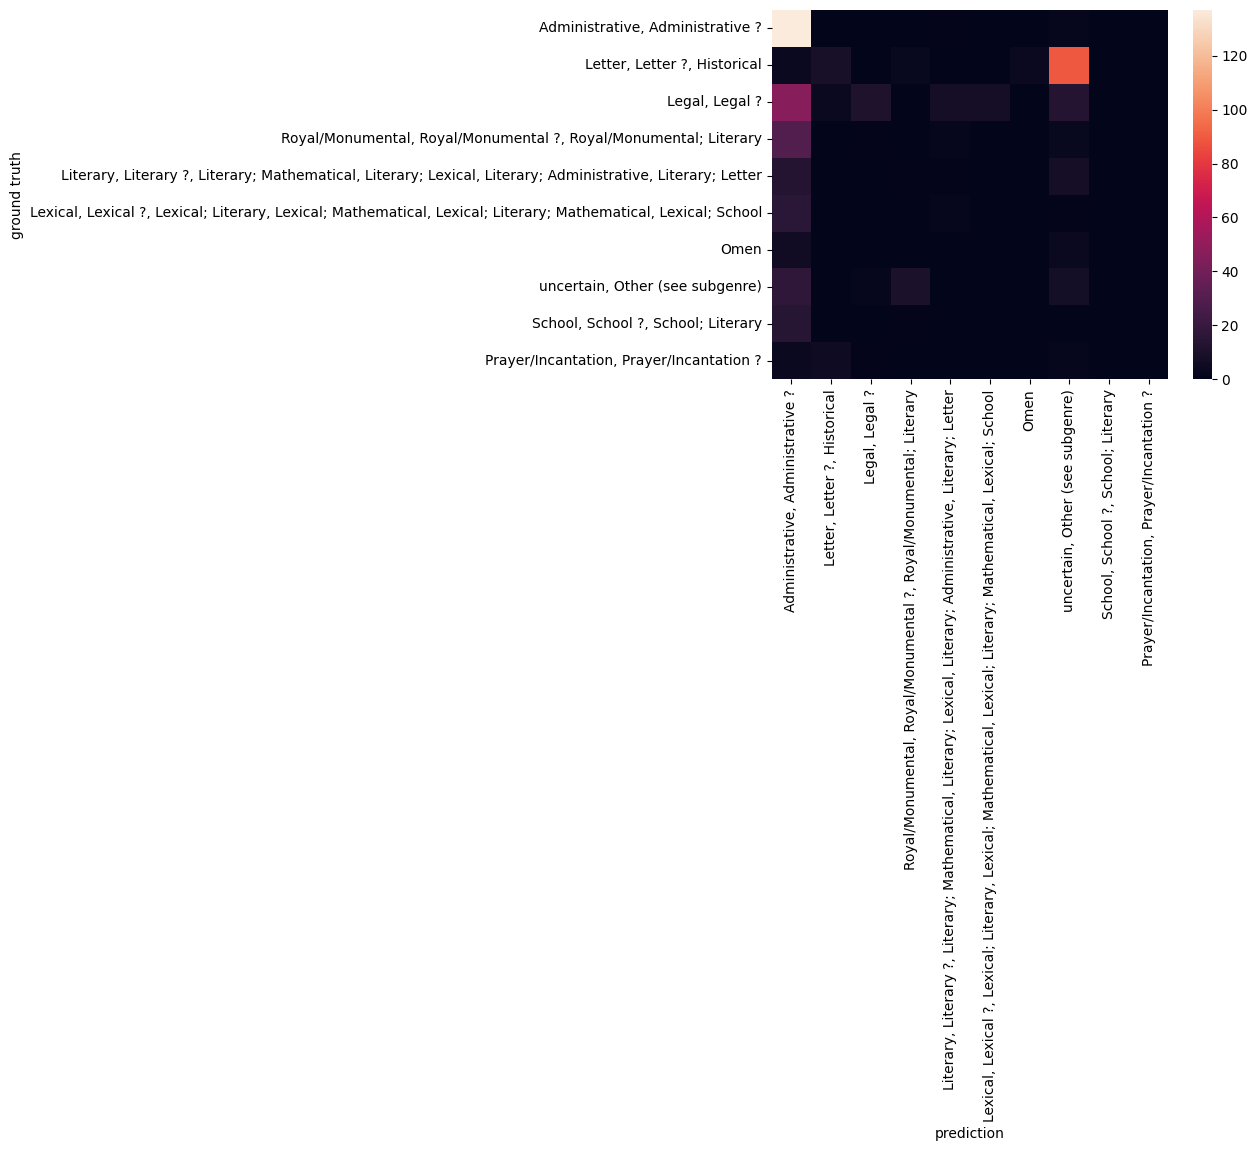

In [36]:
sns.heatmap(cm, xticklabels=GENRE_LABELS_C, yticklabels=GENRE_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [37]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

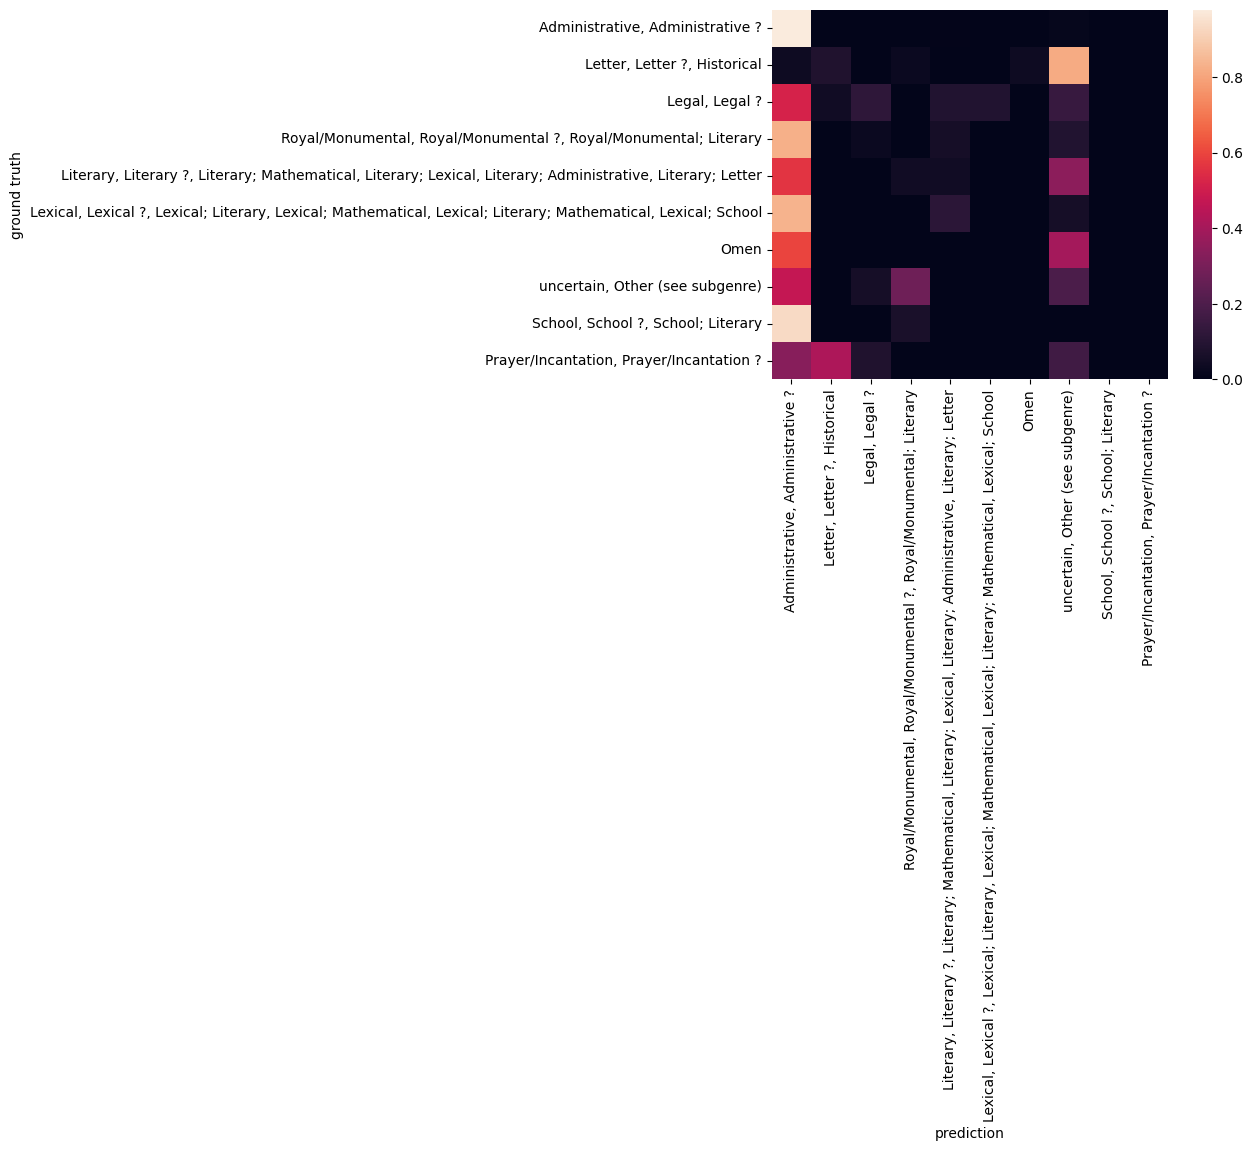

In [38]:
sns.heatmap(cm_rownorm, xticklabels=GENRE_LABELS_C, yticklabels=GENRE_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [39]:
cm_df = pd.DataFrame(cm, columns=GENRE_LABELS_C, index=GENRE_LABELS_C)
cm_df

,"Administrative, Administrative ?","Letter, Letter ?, Historical","Legal, Legal ?","Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary","Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter","Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School",Omen,"uncertain, Other (see subgenre)","School, School ?, School; Literary","Prayer/Incantation, Prayer/Incantation ?"
"Administrative, Administrative ?",137,0,0,0,1,0,0,2,0,0
"Letter, Letter ?, Historical",4,9,0,3,0,0,4,89,0,0
"Legal, Legal ?",47,4,11,0,8,8,0,13,0,0
"Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary",29,0,1,0,2,0,0,3,0,0
"Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter",13,0,0,1,1,0,0,8,0,0
"Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School",15,0,0,0,2,0,0,1,0,0
Omen,6,0,0,0,0,0,0,4,0,0
"uncertain, Other (see subgenre)",17,0,2,10,0,0,0,7,0,0
"School, School ?, School; Literary",14,0,0,1,0,0,0,0,0,0
"Prayer/Incantation, Prayer/Incantation ?",4,5,1,0,0,0,0,2,0,0


In [40]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=GENRE_LABELS_C, index=GENRE_LABELS_C)
cm_rn_df

,"Administrative, Administrative ?","Letter, Letter ?, Historical","Legal, Legal ?","Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary","Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter","Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School",Omen,"uncertain, Other (see subgenre)","School, School ?, School; Literary","Prayer/Incantation, Prayer/Incantation ?"
"Administrative, Administrative ?",0.978571,0.000000,0.000000,0.000000,0.007143,0.000000,0.000000,0.014286,0.0,0.0
"Letter, Letter ?, Historical",0.036697,0.082569,0.000000,0.027523,0.000000,0.000000,0.036697,0.816514,0.0,0.0
"Legal, Legal ?",0.516484,0.043956,0.120879,0.000000,0.087912,0.087912,0.000000,0.142857,0.0,0.0
"Royal/Monumental, Royal/Monumental ?, Royal/Monumental; Literary",0.828571,0.000000,0.028571,0.000000,0.057143,0.000000,0.000000,0.085714,0.0,0.0
"Literary, Literary ?, Literary; Mathematical, Literary; Lexical, Literary; Administrative, Literary; Letter",0.565217,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.347826,0.0,0.0
"Lexical, Lexical ?, Lexical; Literary, Lexical; Mathematical, Lexical; Literary; Mathematical, Lexical; School",0.833333,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.055556,0.0,0.0
Omen,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.0,0.0
"uncertain, Other (see subgenre)",0.472222,0.000000,0.055556,0.277778,0.000000,0.000000,0.000000,0.194444,0.0,0.0
"School, School ?, School; Literary",0.933333,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"Prayer/Incantation, Prayer/Incantation ?",0.333333,0.416667,0.083333,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.0


# Hierarchical clustering on confusion matrix

In [71]:
from scipy.cluster import hierarchy

In [72]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

In [73]:
Z = hierarchy.linkage(Y, method='single')

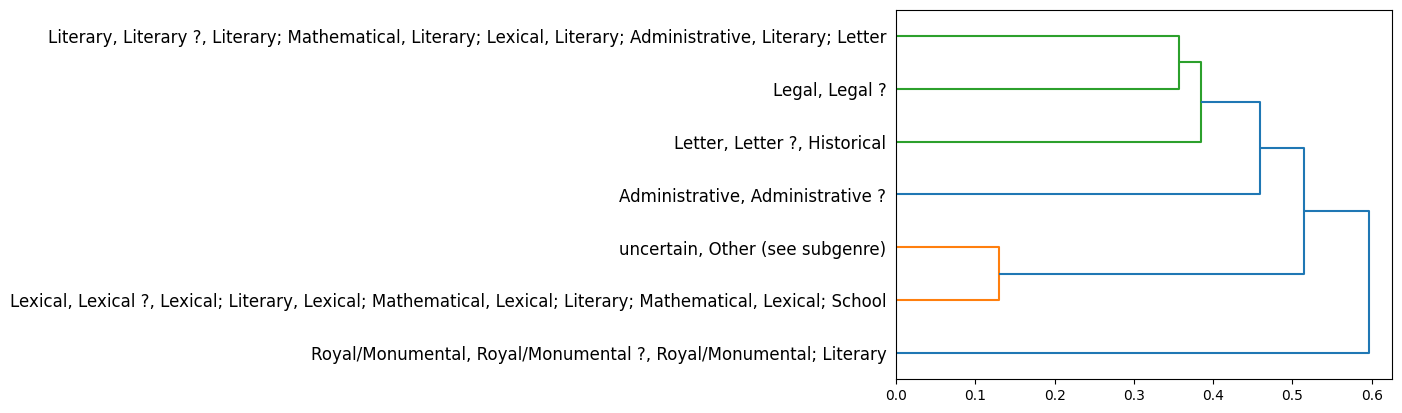

In [74]:
ax = hierarchy.dendrogram(Z, show_contracted=True, labels=GENRE_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [75]:
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt

In [76]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [77]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [78]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)

In [79]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [80]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)
#     y_true = np.hstack(y_true)
#     logits = np.vstack(logits)
#     return logits, y_true

In [81]:
feats_train = extract_features(dl_train)

  0%|          | 0/5943 [00:00<?, ?it/s]

In [82]:
feats = extract_features(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [83]:
feats.shape

(489, 2048)

In [84]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

CPU times: user 8.62 s, sys: 716 ms, total: 9.34 s
Wall time: 1.9 s


In [85]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

CPU times: user 191 ms, sys: 46.1 ms, total: 237 ms
Wall time: 5.15 s


In [86]:
F2

array([[-14.269259  ,   3.5882573 ,   3.396768  , ...,  -7.8525333 ,
         -0.66694933,   1.9883815 ],
       [-19.258945  ,  -1.6776068 ,   4.90696   , ...,  -2.8268032 ,
          0.2136981 ,  -4.214313  ],
       [ -7.588555  ,   1.9771292 ,   0.11343729, ...,   1.0919794 ,
         -8.182434  ,   6.5440016 ],
       ...,
       [ -5.5731487 ,   5.8804865 ,  -5.0894556 , ...,  -5.801985  ,
         -1.1352788 ,   4.341067  ],
       [ -7.6825223 ,  10.740313  ,   8.191403  , ...,   4.10735   ,
         -0.37904292,  -6.345345  ],
       [-10.236114  ,   4.7023    ,  -3.330769  , ...,  -1.6865351 ,
          0.21314183,   4.5145807 ]], dtype=float32)

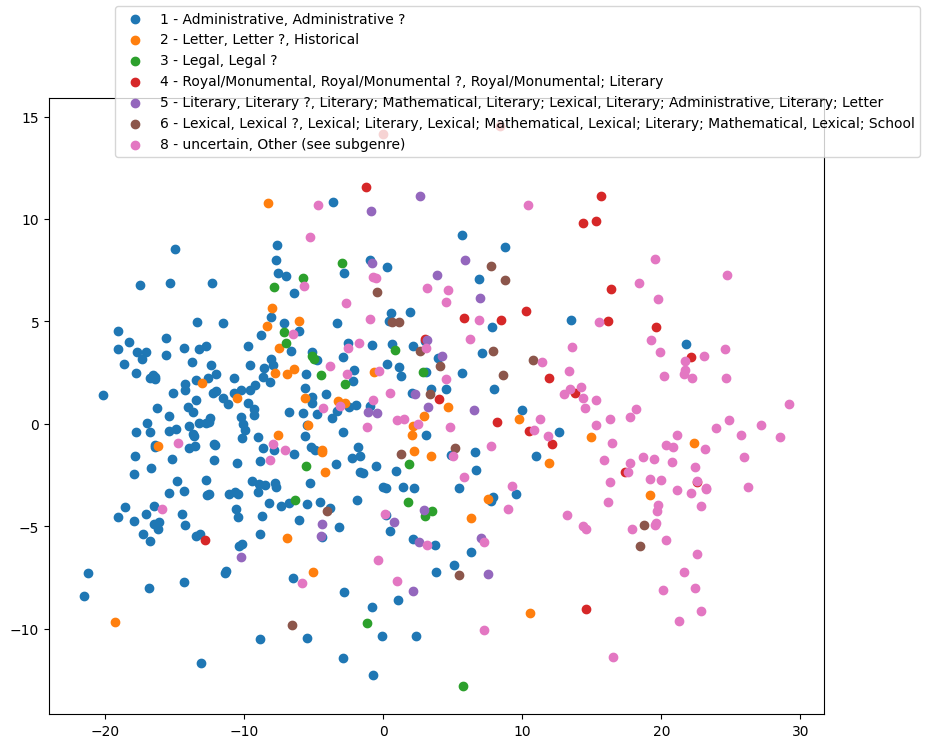

In [89]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for genre in set(y_true_c):
    ax.scatter(F2[y_true_c == genre, 0], F2[y_true_c == genre, 4], label=f'{genre} - {explain(idx2genre[genre])}')
fig.legend();

In [90]:
list(idx2genre.values())

[['Administrative', 'Administrative ?'],
 ['Letter', 'Letter ?', 'Historical'],
 ['Legal', 'Legal ?'],
 ['Royal/Monumental', 'Royal/Monumental ?', 'Royal/Monumental; Literary'],
 ['Literary',
  'Literary ?',
  'Literary; Mathematical',
  'Literary; Lexical',
  'Literary; Administrative',
  'Literary; Letter'],
 ['Lexical',
  'Lexical ?',
  'Lexical; Literary',
  'Lexical; Mathematical',
  'Lexical; Literary; Mathematical',
  'Lexical; School'],
 ['Omen'],
 ['uncertain', 'Other (see subgenre)'],
 ['School', 'School ?', 'School; Literary'],
 ['Mathematical', 'Mathematical ?'],
 ['Prayer/Incantation', 'Prayer/Incantation ?'],
 ['Scientific', 'Scientific ?'],
 ['Ritual', 'Ritual ?'],
 ['fake (modern)', 'fake (modern) ?'],
 ['Astronomical'],
 ['Private/Votive', 'Private/Votive ?']]

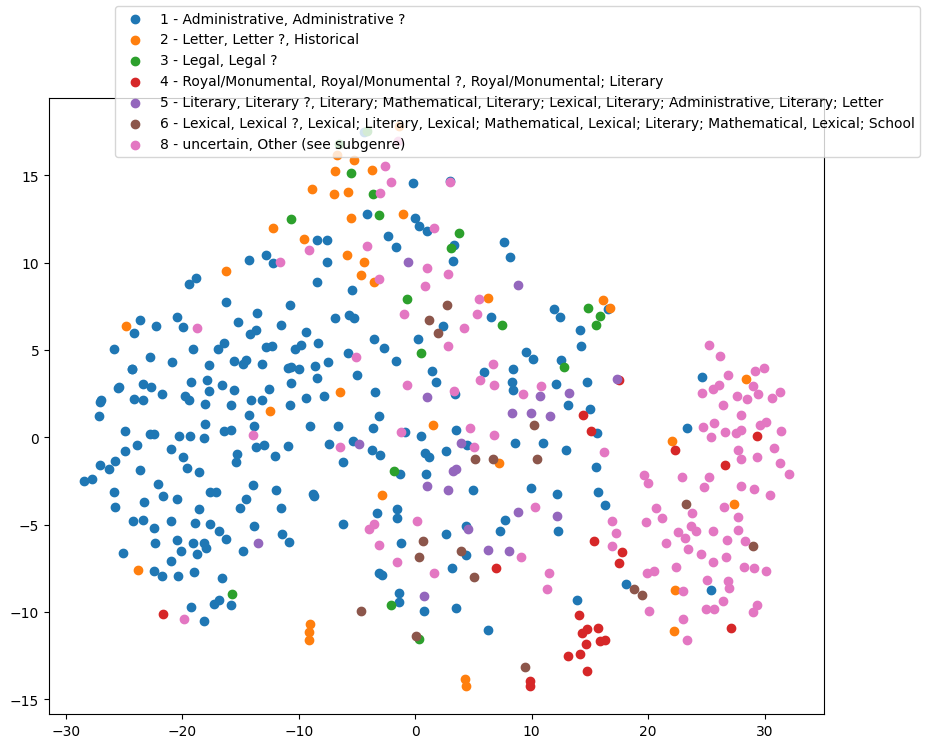

In [91]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for genre in set(y_true_c):
    ax.scatter(F[y_true_c == genre, 0], F[y_true_c == genre, 1], label=f'{genre} - {explain(idx2genre[genre])}')
fig.legend();

In [68]:
plt2 = umap.plot.points(mapper, labels=np.array([idx2period[idx] for idx in y_true_c]), color_key_cmap='Paired', background= 'black')

NameError: name 'umap' is not defined

In [69]:
inv_transformed_points[0].shape

NameError: name 'inv_transformed_points' is not defined

In [70]:
from matplotlib.gridspec import GridSpec
labels = np.array([y_true_c])
corners = np.array([
    [0, 3], 
    [0, 5],  
    [8, 2], 
    [10, 6], 
])


test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

inv_transformed_points = mapper.inverse_transform(test_pts)

# Set up the grid
fig = plt.figure(figsize=(20,12))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(64, 32))
        digit_axes[i, j].set(xticks=[], yticks=[])

NameError: name 'mapper' is not defined

In [92]:
# green
np.where(y_true == 2)

(array([  1, 121, 150, 152, 153, 154, 155, 161, 162, 170, 175, 176, 198,
        200, 202, 206, 208, 209, 232, 269, 270, 271, 282, 283, 284, 285,
        286, 303, 310, 311, 312, 316, 317, 319, 342, 359, 427]),)

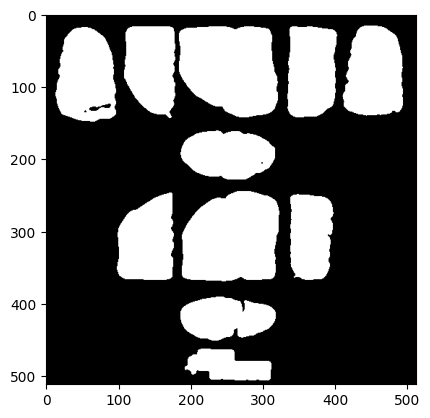

In [93]:
ID = np.random.choice(np.where(y_true == 2)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

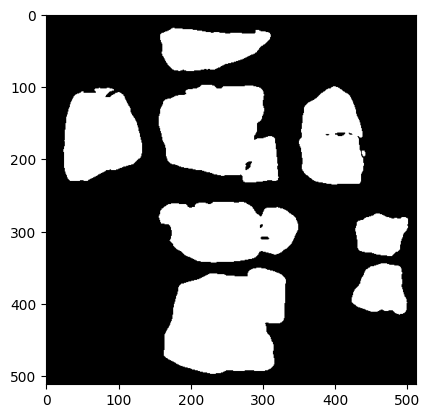

In [94]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

# Visualize mistakes

In [95]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([  1,  38,  45,  70,  87,  90,  92,  97,  99, 110, 112, 115, 116,
       121, 125, 126, 127, 130, 131, 132, 133, 134, 136, 137, 138, 139,
       140, 141, 142, 143, 151, 154, 155, 156, 157, 159, 160, 162, 163,
       164, 167, 168, 169, 172, 173, 176, 178, 179, 180, 181, 182, 184,
       185, 189, 195, 196, 197, 198, 200, 202, 204, 206, 208, 209, 211,
       213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227,
       231, 232, 233, 236, 238, 242, 243, 244, 248, 249, 250, 251, 253,
       254, 255, 256, 257, 258, 259, 261, 262, 263, 265, 267, 270, 271,
       274, 279, 282, 283, 287, 288, 289, 290, 291, 296, 297, 298, 299,
       300, 303, 305, 309, 311, 314, 317, 318, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 339, 350, 351, 356, 358, 360, 361,
       363, 370, 376, 378, 382, 396, 410, 413, 414, 416, 419, 423, 424,
       425, 427, 428, 433, 439, 440, 442, 444, 445, 448, 451, 453, 458,
       462, 464, 466, 468, 473, 474, 476, 478, 482, 483, 484, 48

In [96]:
mistake_indices.shape

(183,)

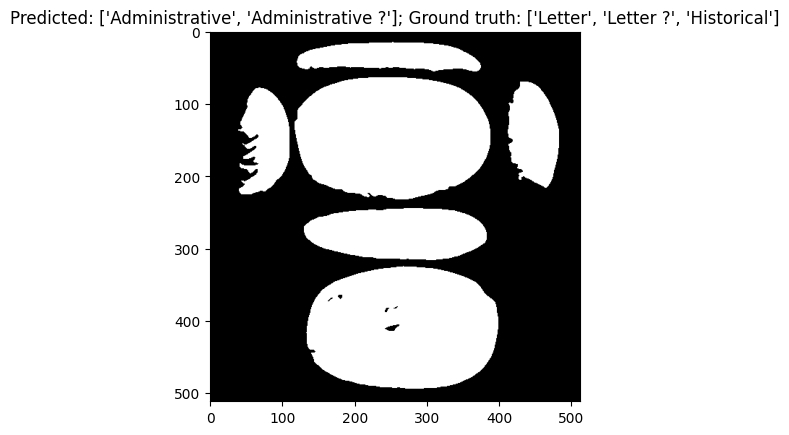

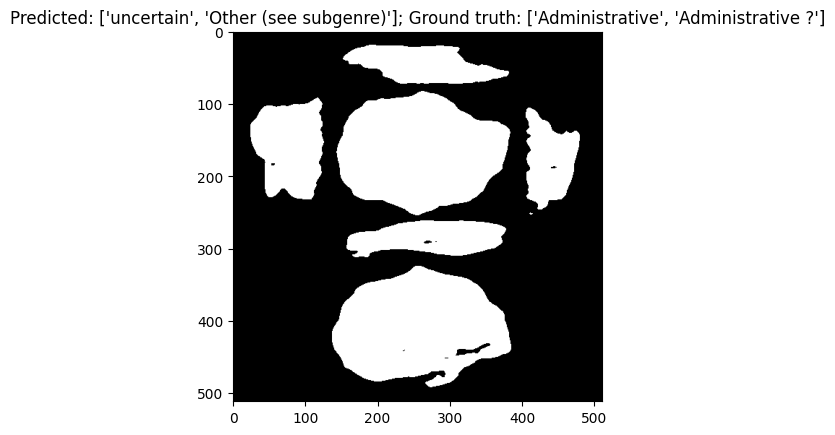

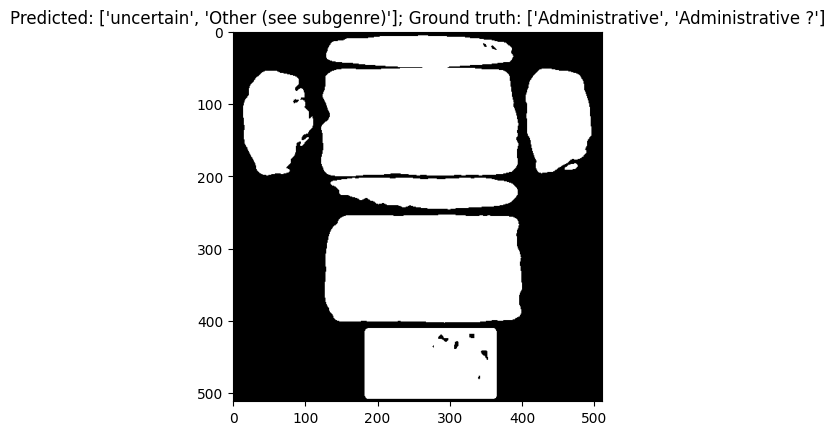

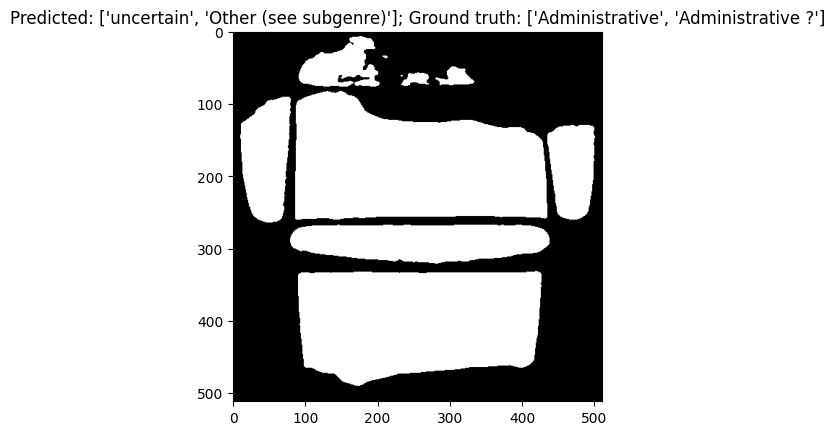

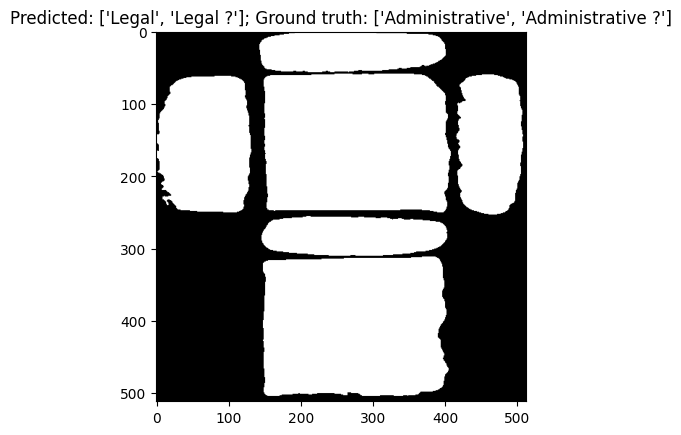

In [98]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2genre[pred]}; Ground truth: {idx2genre[y]}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [71]:
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [76]:
# for i in range(10):
#     explain_idx(i)